# Fetch and export SNOTEL sites and daily time series data
11/5, 6/23, 2/29/2020. https://github.com/emiliom/

In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import ulmo

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##USER INPUTS## - most of this can be read directly from the .ctl file or the .par file 
#-> need to read in text file
#start date
st = "2014-10-01"
#end date
ed = "2019-09-29"


#Snotel bounding box
Bbox = {
    'latmax' : 44.582480,
    'latmin' : 42.363116,
    'lonmax': -109.477849,
    'lonmin': -111.155208,}

# Snotel projection
stn_proj = 'epsg:4326' #WGS84
#model projection
mod_proj = 'epsg:32612' #UTM zone 12N

# Use ulmo to get SNOTEL station metadata within bounding box
## Get SNOTEL metadata over modeling domain

In [3]:
#function to extract data
def sites_asgdf(ulmo_getsites, crs=stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

In [4]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

In [5]:
# WaterML/WOF WSDL endpoint url 
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)

In [6]:
CSO_gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
CSO_gdf.drop(columns='index_right', inplace=True)
CSO_gdf.reset_index(drop=True, inplace=True)
#CSO_gdf.index = CSO_gdf['code']

#add columns with projected coordinates 
CSO_proj = CSO_gdf.to_crs(mod_proj)
CSO_gdf['easting'] = CSO_proj.geometry.x
CSO_gdf['northing'] = CSO_proj.geometry.y

CSO_gdf.head()

,code,longitude,latitude,name,elevation_m,geometry,easting,northing
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,POINT (-110.44544 43.94019),544505.845453,4.865379e+06
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,POINT (-111.12803 44.50832),489823.440274,4.928341e+06
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,POINT (-109.79333 44.37667),596129.923439,4.914418e+06
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,POINT (-110.60973 42.96400),531828.554679,4.756891e+06
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,POINT (-109.67021 43.69733),607155.527746,4.839116e+06


In [7]:
len(CSO_gdf)

32

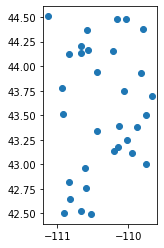

In [8]:
CSO_gdf.plot();

## Get SNOTEL SWE data in domain over time period of interest

In [9]:
#Emilio code

def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [10]:
stn_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for sitecode in CSO_gdf.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=st, end_date=ed)
        stn_swe[sitecode] = swe.value
    except:
        print(sitecode, 'has no data')
        stn_swe[sitecode] = np.nan

314_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
347_MT_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
350_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
353_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
379_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
419_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
421_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
421_WY_SNTL has no data
460_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
468_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
1082_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
497_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
499_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
506_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
944_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
555_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
577_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
585_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
597_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
661_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
689_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
730_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
764_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
765_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
779_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
806_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
807_WY_SNTL SNOTEL:WTEQ_D 2014-10-01 2019-09-29
816_WY_SNTL SNOTEL:WTEQ_D 2014-10

In [11]:
stn_swe.head()

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,379_WY_SNTL,419_WY_SNTL,421_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,...,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL,878_WY_SNTL
2014-10-01,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.9,...,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.6,0.0,NaN
2014-10-02,0.0,0.0,0.2,0.0,0.0,0.0,NaN,0.0,0.0,1.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,NaN
2014-10-03,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,NaN
2014-10-04,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2014-10-05,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
#convert SNOTEL units[in] to SnowModel units [m]
for sitecode in CSO_gdf.code:
    # overwrite the original values (no use for the original values in inches)
    stn_swe[sitecode] = 0.0254 * stn_swe[sitecode]

stn_swe.head()

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,379_WY_SNTL,419_WY_SNTL,421_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,...,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL,878_WY_SNTL
2014-10-01,0.0,0.0,0.00000,0.0,0.0,0.0,NaN,0.0,0.0,0.02286,...,0.0,0.0,0.00762,0.0,0.0,0.0,0.0,0.01524,0.0,NaN
2014-10-02,0.0,0.0,0.00508,0.0,0.0,0.0,NaN,0.0,0.0,0.03048,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.01778,0.0,NaN
2014-10-03,0.0,0.0,0.00000,0.0,0.0,0.0,NaN,0.0,0.0,0.02794,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.01524,0.0,NaN
2014-10-04,0.0,0.0,0.00000,0.0,0.0,0.0,NaN,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,NaN
2014-10-05,0.0,0.0,0.00000,0.0,0.0,0.0,NaN,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,NaN


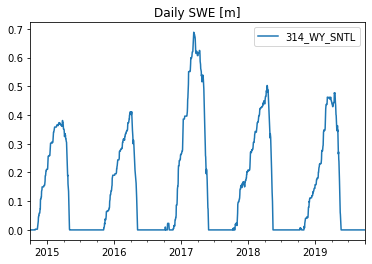

In [13]:
stn_swe.plot(y='314_WY_SNTL', title='Daily SWE [m]');

## Export the sites and daily time series to files, for reuse
- CSO_gdf to GeoJSON
- stn_swe to csv or parquet

**Note:** Sometimes the statement below produces this warning:
```
CSO_SNOTEL_sites.geojson: No such file or directory 
driver GeoJSON does not support creation option ENCODING
```

Ignore it. The GeoJSON file is still written out without issues.

In [14]:
CSO_gdf.to_file('CSO_SNOTEL_sites.geojson', driver='GeoJSON')

In [15]:
len(stn_swe)

1825

In [16]:
# The file that's written is tiny, only 0.5 MB
stn_swe.to_csv('CSO_SNOTEL_data_SWEDmeters.csv')